# 数据预处理

In [1]:
# R 代码
# 加载库
library(tidyverse)

# 读取数据（假设文件为TSV格式）
data <- read_tsv("../examples/merged_counts.tsv") %>%
  column_to_rownames("Contig")

# 检查缺失值
sum(is.na(data))  # 若无缺失值则无需处理

# 过滤低丰度病毒（例如：保留在至少20%样本中计数>50的病毒）
filtered_data <- data[rowSums(data > 500) >= 0.2*ncol(data), ]
dim(data)
dim(filtered_data)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 3417 Columns: 59
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Contig
dbl (58): TXAS01, TXAS02, TXAS06, TXAS09, TXAS10, TXAS11, TXAS12, TXAS14, TX...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quie

[1] 0

[1] 3417   58

[1] 1883   58

# 差异分析

In [2]:
# R 代码（使用DESeq2）
library(DESeq2)

# 创建分组信息（假设列名以TXAS为AS，TXHC为HC）
sample_names <- colnames(data)
group <- ifelse(grepl("^TXAS", sample_names), "AS", "HC")

# 构建DESeq2对象
dds <- DESeqDataSetFromMatrix(
  countData = round(filtered_data),  # 输入整数型计数数据
  colData = data.frame(condition = factor(group)),
  design = ~ condition
)

# 运行差异分析
dds <- DESeq(dds)
res <- results(dds, contrast = c("condition", "AS", "HC"))
rld <- rlog(dds, blind=FALSE)  # 替代之前的log1p
normalized_data <- assay(rld)
# 提取显著结果（p < 0.05且|log2FC| > 1）
sig_res <- res[!is.na(res$padj) & res$padj < 0.05 & abs(res$log2FoldChange) > 1, ]
write.csv(sig_res, "significant_viruses.csv")

载入需要的程序包：S4Vectors

载入需要的程序包：stats4

载入需要的程序包：BiocGenerics


载入程序包：'BiocGenerics'


The following objects are masked from 'package:lubridate':

    intersect, setdiff, union


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



载入程序包：'S4Vectors'


The following objects are masked from 'package:lubridate':

    second, second<-


The following objects are masked from 'package:dplyr':

    first, rename


T

# 分析数据

## 热图分析

In [16]:
library(pheatmap)
heatmap_colors <- colorRampPalette(c("navy", "white", "red3"))(256)
pheatmap(
  normalized_data[sig_genes, ],
  scale = "row",
  color = heatmap_colors,
  annotation_col = data.frame(Group = group, row.names = colnames(normalized_data)),
  show_rownames = FALSE,
  main = "Z-Score Normalized Expression",
  border_color = NA,
  clustering_method = "ward.D2"
)

ERROR: Error in normalized_data[sig_res, ]: 类别为'S4'的下标无效


In [18]:
# R 代码
library(EnhancedVolcano)

EnhancedVolcano(
  res,
  lab = rownames(res),
  x = "log2FoldChange",
  y = "padj",
  pCutoff = 0.05,
  FCcutoff = 1
)

ERROR: Error in EnhancedVolcano(dds, lab = rownames(res), x = "log2FoldChange", : log2FoldChange is not numeric!


载入需要的程序包：permute

载入需要的程序包：lattice

This is vegan 2.6-8



删除的离群样本：
[1] "TXAS15" "TXAS50" "TXHC27"


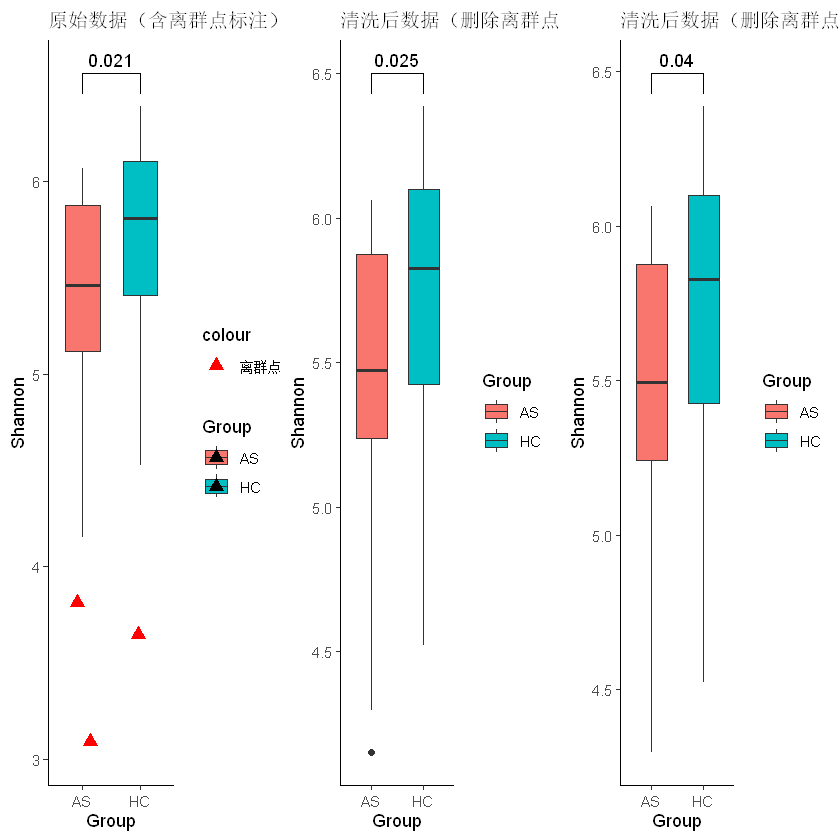

In [12]:
library(vegan)
library(ggplot2)
library(ggpubr)

# 生成原始数据
alpha_diversity <- vegan::diversity(t(counts(dds, normalized = TRUE)), index = "shannon")
alpha_df <- data.frame(Group = group, Shannon = alpha_diversity, Sample = names(alpha_diversity))

# 定义离群点函数（针对每个组独立检测）
detect_group_outliers <- function(data, group_var) {
  data %>%
    group_by(Group) %>%
    mutate(
      Q1 = quantile(Shannon, 0.25, na.rm = TRUE),
      Q3 = quantile(Shannon, 0.75, na.rm = TRUE),
      IQR = Q3 - Q1,
      Lower = Q1 - 1.5 * IQR,
      Upper = Q3 + 1.5 * IQR,
      is_outlier = Shannon < Lower | Shannon > Upper
    ) %>%
    ungroup()
}

# 检测离群点
alpha_df <- detect_group_outliers(alpha_df, Group)

# 可视化：标注离群点
p_raw <- ggplot(alpha_df, aes(x = Group, y = Shannon, fill = Group)) +
  geom_boxplot(width = 0.6, outlier.shape = NA) +  # 先隐藏默认离群点
  geom_jitter(
    data = filter(alpha_df, is_outlier),
    aes(color = "离群点"),
    width = 0.2,
    size = 3,
    shape = 17
  ) +
  stat_compare_means(
    method = "wilcox.test",
    label = "p.format",
    comparisons = list(c("AS", "HC")),
    label.x = 1.5
  ) +
  scale_color_manual(values = c("离群点" = "red")) +
  labs(title = "原始数据（含离群点标注）") +
  theme_classic()

# 删除离群点
alpha_clean <- alpha_df %>% filter(!is_outlier)

# 可视化清洗后数据
p_clean1 <- ggplot(alpha_clean, aes(x = Group, y = Shannon, fill = Group)) +
  geom_boxplot(width = 0.6) +
  stat_compare_means(
    method = "wilcox.test",
 label = "p.format",
    comparisons = list(c("AS", "HC")),
    label.x = 1.5
  ) +
  labs(title = "清洗后数据（删除离群点）") +
  theme_classic()

# 并排显示


# 输出清洗后样本信息
cat("删除的离群样本：\n")
print(alpha_df$Sample[alpha_df$is_outlier])

alpha_df <- detect_group_outliers(alpha_clean, Group)
alpha_clean <- alpha_df %>% filter(!is_outlier)
# 可视化清洗后数据
p_clean <- ggplot(alpha_clean, aes(x = Group, y = Shannon, fill = Group)) +
  geom_boxplot(width = 0.6) +
  stat_compare_means(
    method = "wilcox.test",
 label = "p.format",
    comparisons = list(c("AS", "HC")),
    label.x = 1.5
  ) +
  labs(title = "清洗后数据（删除离群点2）") +
  theme_classic()
  gridExtra::grid.arrange(p_raw,p_clean1, p_clean, ncol = 3)


载入程序包：'ape'


The following object is masked from 'package:ggpubr':

    rotate


The following object is masked from 'package:dplyr':

    where


Warning message in vegdist(t(normalized_data), method = "bray"):
"results may be meaningless because data have negative entries
                 in method "bray""


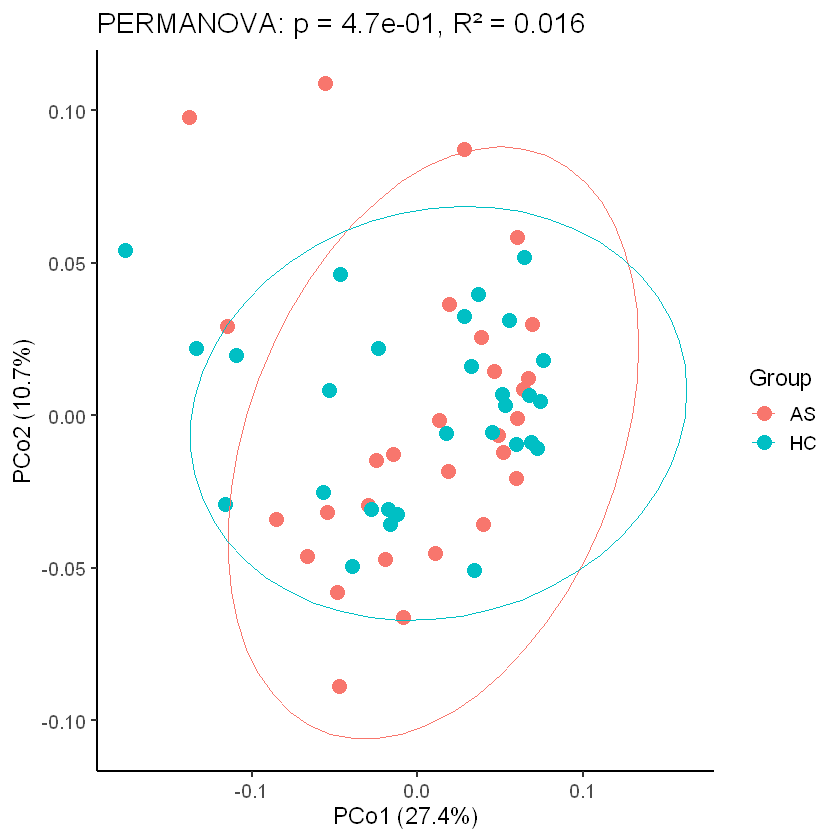

In [13]:
library(vegan)
library(ape)
library(ggplot2)

dist_matrix <- vegdist(t(normalized_data), method = "bray")
pcoa_result <- pcoa(dist_matrix)
pcoa_scores <- as.data.frame(pcoa_result$vectors[, 1:2])
colnames(pcoa_scores) <- c("PCo1", "PCo2")
pcoa_scores$Group <- group
adonis_result <- adonis2(dist_matrix ~ group, permutations = 999)
p_value <- adonis_result$`Pr(>F)`[1]
r_squared <- adonis_result$R2[1]
ggplot(pcoa_scores, aes(x = PCo1, y = PCo2, color = Group)) +
  geom_point(size = 4) +
  stat_ellipse(level = 0.95) +
  labs(
    x = paste0("PCo1 (", round(pcoa_result$values$Relative_eig[1] * 100, 1), "%)"),
    y = paste0("PCo2 (", round(pcoa_result$values$Relative_eig[2] * 100, 1), "%)"),
    title = paste0("PERMANOVA: p = ", format(p_value, scientific = TRUE, digits = 2), ", R² = ", round(r_squared, 3))
  ) +
  theme_classic(base_size = 14)

# 网络分析

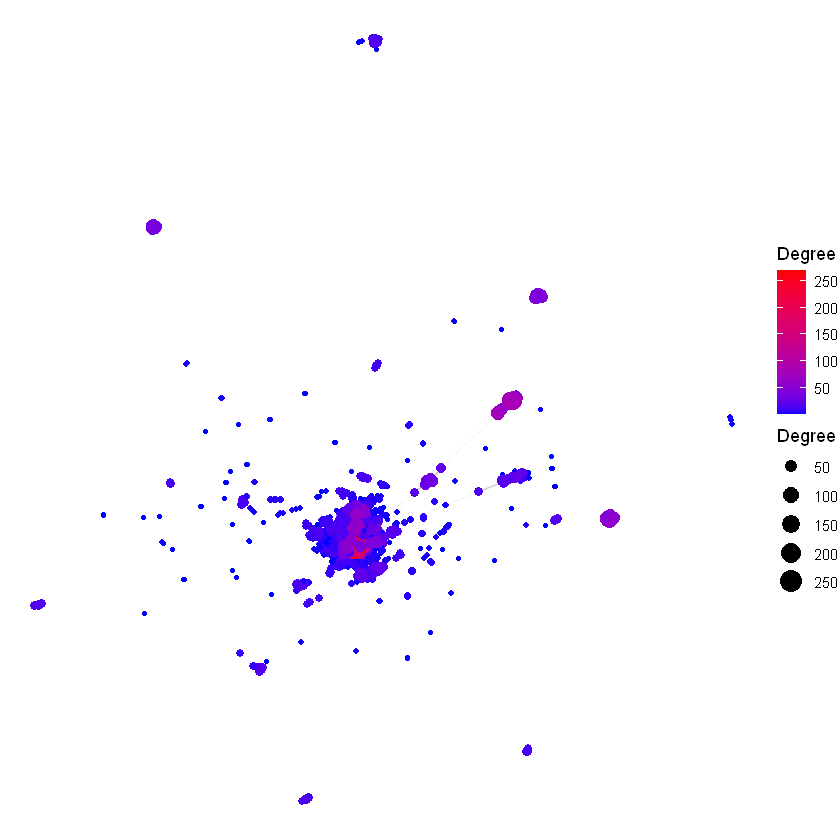

In [20]:
library(igraph)

# 计算相关性矩阵（使用DESeq2标准化后的数据）
cor_matrix <- cor(t(normalized_data), method = "spearman")
cor_threshold <- 0.6  # 调整阈值以增加/减少连接数
adj_matrix <- ifelse(abs(cor_matrix) > cor_threshold & cor_matrix != 1, 1, 0)

# 构建网络
net <- graph_from_adjacency_matrix(adj_matrix, mode = "undirected", diag = FALSE)

# 显式调用igraph包的degree函数
degrees <- igraph::degree(net)

# 移除孤立节点（度数=0的节点）
net <- delete_vertices(net, V(net)[degrees == 0])

# 重新计算度数（过滤后）
degrees_filtered <- igraph::degree(net)

# 可视化网络（按度数大小着色）
ggraph(net, layout = "fr") +
  geom_edge_link(alpha = 0.1, color = "grey") +
  geom_node_point(aes(size = degrees_filtered, color = degrees_filtered)) +
  scale_color_gradient(low = "blue", high = "red", name = "Degree") +
  scale_size(name = "Degree") +
  theme_void()